![](../img/330-banner.png)

Lecture 20: Survival analysis 
-------------------

UBC 2022-23 W2

Instructor: Amir Abdi

Office Hours: Mondays 5-6 PM

Anonymous Feedback: https://forms.gle/t21FhAVG8aY2mFs56

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

plt.rcParams["font.size"] = 12

# does lifelines try to mess with this?
pd.options.display.max_rows = 10

In [ ]:
# new package we will learn today
import lifelines

### Announcements
- HW8 (**the very last homework!**) due April 12, 11:59pm

## Learning objectives

- Explain what is **censored** data. 
- Determine whether survival analysis is an appropriate tool for a given problem.
- Apply survival analysis in Python using the `lifelines` package.
- Interpret a **survival curve, such as the Kaplan-Meier curve**.
- Interpret the coefficients of a fitted **Cox proportional hazards model**.
- Make predictions for existing individuals and interpret these predictions.

## Customer churn: our standard approach

- Imagine that you are working for a subscription-based telecom company. 
- You want to come up with retention strategies for different customer segments. 
- So you want to model the "time to churn" to understand different factors affecting customer churn.   
- Suppose you are given this dataset [Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn), which is collected at a fixed time. 

In [ ]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_df, test_df = train_test_split(df, random_state=123)
train_df.head()

- We are interested in predicting customer churn: the "Churn" column.  
  - **Customers who left within the last month**
  - **We are only looking at a snapshot of a system at a certain point in time**
- How will you approach this problem with the approaches we have seen so far? 
- How about treating this as a binary classification problem where we want to predict `Churn` (yes/no) from these -other columns.
- Before we look into survival analysis, let's just treat it as a binary classification model where we want to predict whether a customer churned or not. 

In [ ]:
train_df.shape

In [ ]:
train_df["Churn"].value_counts()

In [ ]:
train_df.info()

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [ ]:
train_df["SeniorCitizen"].value_counts()

In [ ]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
drop_features = ["customerID"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

--------------

**[Study on your own]**

### Data Cleaning

In [ ]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [ ]:
# The following wouldn't work because there are some " " (whitespace) values in 'TotalCharges'
# preprocessor.fit(train_df);

Hmmm, one of the numeric features is causing problems?

Oh, looks like `TotalCharges` is not a numeric type. What if we change the type of this column to float? 

In [ ]:
train_df["TotalCharges"]

In [ ]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print(f'value "{val}" is not float')

Well, it turns out we can't see those problematic values because they are whitespace!

Let's replace the whitespaces with NaNs. 

In [ ]:
train_df = train_df.assign(
    TotalCharges=train_df["TotalCharges"].replace(" ", np.nan).astype(float)
)
test_df = test_df.assign(
    TotalCharges=test_df["TotalCharges"].replace(" ", np.nan).astype(float)
)

In [ ]:
train_df.info()

But now we are going to have missing values and we need to include imputation for numeric features in our preprocessor. 

**[end of Study on your own]**

--------------

In [ ]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

Now let's try that again...

In [ ]:
preprocessor.fit(train_df);

It worked! Let's get the column names of the transformed data from the column transformer.

In [ ]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [ ]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)

In [ ]:
X_train_enc.head()

In [ ]:
results = {}

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

y_train = train_df["Churn"]
y_test = test_df["Churn"]

### DummyClassifier

In [ ]:
dc = DummyClassifier()

In [ ]:
results["dummy"] = mean_std_cross_val_scores(
    dc, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

Dummy model scores are pretty good because we have class imbalance. 

In [ ]:
y_train.value_counts()

### LogisticRegression

In [ ]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [ ]:
results["logistic regression"] = mean_std_cross_val_scores(
    lr, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

- Logistic regression beats the dummy model. 
- But it seems like we have many false negatives. 

### RandomForestClassifier

Let's try random forest model. 

In [ ]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100))

In [ ]:
results["random forest"] = mean_std_cross_val_scores(
    rf, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

In [ ]:
confusion_matrix(y_train, cross_val_predict(rf, X_train, y_train))

- Random forest is not improving the scores. 

### Attention
- After trying out all the usual things **should we be happy with the scores?**
- Are we doing anything **fundamentally WRONG** when we treat this problem as a binary classification? 
<br><br><br><br><br><br><br>

The rest of the class is about what is **WRONG** with what we just did :-)

## Censoring and survival analysis

### Time to event and censoring

- When we treat the problem as a binary classification problem, we predict whether a customer would churn or not at a particular point in time, when the data was collected. 
- If a customer has not churned yet, wouldn't it be more useful to understand when they are likely to churn so that we can offer them promotions etc?  
- Here we are actually interested in the time till the event of churn occurs.  

There are many situations where you want to analyze **the time until an event occurs**. For example,

- the time until a customer leaves a subscription service (this dataset)
- the time until a disease kills its host
- the time until a piece of equipment breaks
- the time that someone unemployed will take to land a new job
- the time until you wait for your turn to get a surgery

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". 

We are interested in 
- **the time until something happens**,   
or 
- **whether or not something will happen in a certain time frame**.

In our dataset there is a column called "tenure", which encodes this temporal aspect of the data (**number of months the customer has stayed with the company**)

In [ ]:
train_df[["tenure"]].head()

But we only have **tenure** till the point we collected the data. 

**Question:** But why is this different? Can't you just use the techniques you learned so far (e.g., regression models) to predict the time (tenure in our case)? 

Answer: ???

<br><br><br><br><br><br>

<!-- Answer: If you could **observe the actual time** in all occurrences (but you usually cannot).   
Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied. -->

<br><br><br><br>
**censoring in survival analysis**: 
Censoring occurs when the event of interest is not observed for some subjects before the study is terminated.

**Right Censoring**: When a subject leaves the study before an event occurs, or the study ends before the event has occurred.

(there are other types of censoring)

<br><br><br><br>

In [ ]:
train_df[["tenure", "Churn"]].head()

- What this means is that we **don't have correct target values** to train or test our model.
- This is a problem!

Let's consider some approaches to deal with this **censoring** issue.

### Approach 1: Only consider the examples where "Churn"=Yes

Let's just consider the cases **_for which we have the actual time_**, to obtain the average subscription length.

In [ ]:
train_df_churn = train_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
test_df_churn = test_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
train_df_churn.head()

In [ ]:
train_df.shape

In [ ]:
train_df_churn.shape

In [ ]:
numeric_features

In [ ]:
preprocessing_notenure = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features[1:],  # Getting rid of the tenure column
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
)

In [ ]:
tenure_lm = make_pipeline(preprocessing_notenure, Ridge())

tenure_lm.fit(train_df_churn.drop(columns=["tenure"]), train_df_churn["tenure"]);

Predict on **test** set:

In [ ]:
y_test_tenure = tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))
pd.DataFrame(
    y_test_tenure[:10],
    columns=["tenure_predictions"],
)

In [ ]:
print('average tenure:', y_test_tenure.mean())

`tenure_ml` model is trained on only **churned** samples.

What do you think about our `tenure_ml` model?
- Does it suffer from any biases?
- Is it underestimating the `tenure` or overestimating the `tenure` (given other features)?


Answer: ????
<br><br><br><br><br><br><br>

<!-- On average they will be **underestimates** (too small), because we are ignoring the currently subscribed (un-churned) customers. Our dataset is a biased sample of those who churned within the time window of the data collection. Long-time subscribers were more likely to be removed from the dataset! This is a common mistake - see the [Calling Bullshit video](https://www.youtube.com/watch?v=ITWQ5psx9Sw) from the README! -->

<br><br>

### Approach 2: Assume everyone churns right now

Assume everyone churns right now - in other words, use the original dataset. 

In [ ]:
train_df[["tenure", "Churn"]].head()

In [ ]:
tenure_lm.fit(train_df.drop(columns=["tenure"]), train_df["tenure"]);

In [ ]:
y_test_tenure = tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))
pd.DataFrame(
    y_test_tenure[:10],
    columns=["tenure_predictions"],
)

In [ ]:
print('average tenure:', y_test_tenure.mean())

This `tenure_ml` model is trained on all samples (churn and not-churn).

What do you think about our `tenure_ml` model?

- Does it suffer from any biases?
- Is it underestimating the tenure or overestimating the tenure (given other features)?

Answer: ????
<br><br><br><br><br><br>

<!-- It will be an **underestimate** again. For those still subscribed, while we did not remove them, we recorded a total tenure shorter than in reality, because they will keep going for some amount of time.  -->

<br><br>

### Approach 3: Survival analysis

Deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

**Survival Analysis: analyzing the expected duration of time until one event occurs**

- You may learn about this in a statistics course.
- We will use the `lifelines` package in Python and will not go into the math/stats of how it works.

In [ ]:
train_df[["tenure", "Churn"]].head()

#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. For a particular customer, can we predict how long they might stay with the service?
3. What factors influence a customer's churn time?

## Break (5 min)

![](../img/eva-coffee.png)


## Kaplan-Meier survival curve

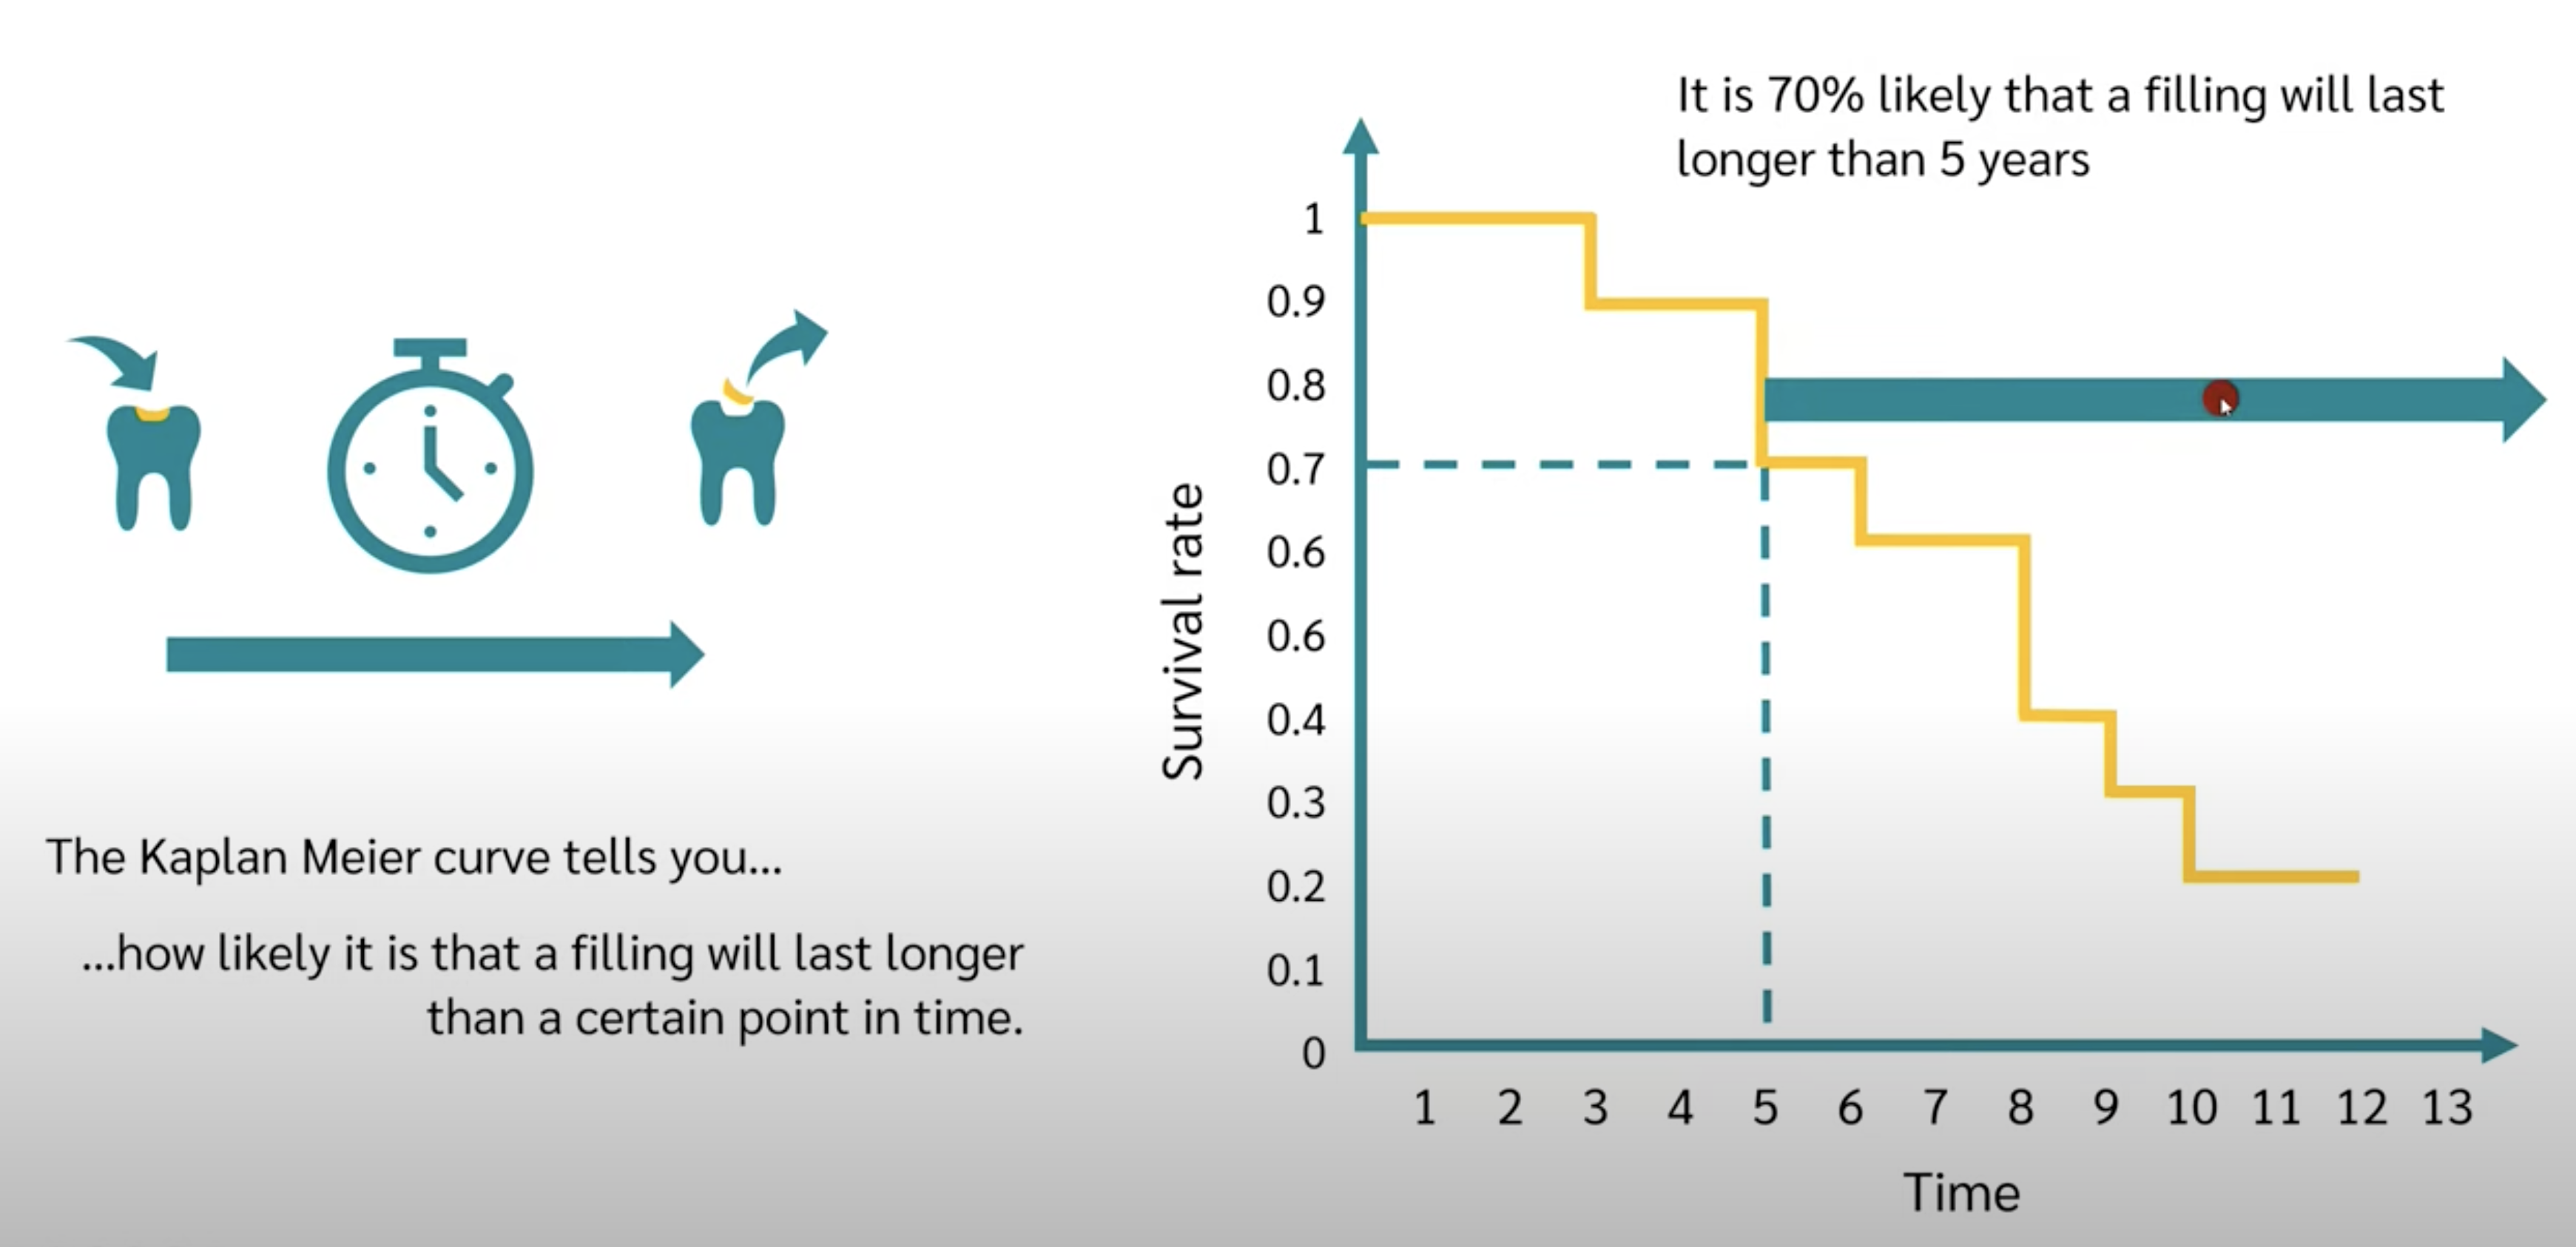

[img source](https://www.youtube.com/watch?v=L_ziqYhksG8)

Before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm going to not scale the `tenure` column, as **it will be more convenient for teaching purpises** to keep it in its original units of months. 

Just for our sanity, I'm redefining the features. 

In [ ]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen"]  # don't want to scale tenure
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [ ]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == "Yes"),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    ("drop", drop_features),
)

In [ ]:
preprocessing_final.fit(train_df);

Let's get the column names of the columns created by our column transformer. 

In [ ]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

In [ ]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [ ]:
train_df_surv.head()

- We'll start with a model called `KaplanMeierFitter` from `lifelines` package to get a **Kaplan Meier curve**.  
- For this model we only use two columns: **tenure** and **churn**. 
  - We do not use any other features. 

In [ ]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(
    durations=train_df_surv["tenure"], 
    event_observed=train_df_surv["Churn"]
);

In [ ]:
kmf.survival_function_.plot();
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

What is this plot telling us?
- It shows the **probability of survival over time**.
- For example, after 20 months the probability of survival is ~0.8. 
- Over time it's going down. 

**What's the average tenure?**

Which of the following 3 is a better estimate?

1. Average of all tenures

In [ ]:
np.mean(train_df_surv["tenure"])

2. What's the average tenure of the people who churned

In [ ]:
np.mean(train_df_surv.query("Churn == 1.0")["tenure"])

3. What's the average tenure of the people who did not churn

In [ ]:
np.mean(train_df_surv.query("Churn == 0.0")["tenure"])

<br><br><br><br>
- Let's look at the histogram of number of people who **have not churned**. 
- The key point here is that people _joined at different times_. 

In [ ]:
plt.figure(figsize=(4, 3))
train_df_surv[train_df_surv['Churn'] == 0]["tenure"].hist(grid=False)
plt.xlabel("months");

Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.

<br><br><br><br>
Now, let's get back to the **lifelong** library

In Kaplan-Meier survival analysis, 
- Mean survival: The mean survival time is estimated as the area under the survival curve in the interval 0 to $t_{max}$
- Median survival: The median survival is the smallest time at which the survival probability drops to 0.5 (50%) or below

Q: What is the Median Survival value in the above Kaplan-Meier curve?

A: ????

In [ ]:
kmf.median_survival_time_

`???` in this library means: ... ???

In [ ]:
kmf.survival_function_

Lifelines can also give us some "error bars":

In [ ]:
kmf.plot()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- We already have some actionable information here.
- The **curve drops down fast at the beginning** suggesting that **people tend to leave early on**. 
  - If there would have been a big drop in the curve, it means a bunch of people left at that time (e.g., after a 1-month free trial). 
- BTW, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 62,000 times!

We can also create the K-M curve for different subgroups:

In [ ]:
T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

In [ ]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

<br><br>

## Cox proportional hazards model

- We haven't been incorporating other features in the model so far. 
- The Cox proportional hazards model is a commonly used model that allows us to **interpret how features influence a censored tenure/duration**. 
- You can think of it like **feature importance for survival analysis**: 
  - we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (**proportional hazards assumption**) that may not be true, but we won't go into this here.
- **The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.** (What?!! Don't worry, you'll figure it out!)

---------
What is hazard?
- The probability that a subect who is under observation has an **event** at that time


**proportional hazards assumption**: 
- The hazards are proportional, i.e., the **relative hazard** remains **constant** over **time** (ratio of hazard to baseline hazard is constant)

Relative to what?
- Relative to the **baseline hazard**


What is **baseline hazard**?
- It corresponds to the value of the hazard if **all the features are equal to zero** (i.e., the intercept).

---------

Now, read the **proportional hazards assumption** one more time and see if it makes sense.

---------

In [ ]:
cph = lifelines.CoxPHFitter()
# cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

-----------
(Optional)

**Collinearity**: linear dependence of columns (here: features) of the matrix
  - **Collinearity in simpler terms**: when some columns are linear combinations of the other columns  

To learn why **Collinearity** is a problem for matrix inversion, check this out: https://www.stat.cmu.edu/~larry/=stat401/lecture-17.pdf

------------------

- Going to [this URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - We're adding **regularization**; `lifelines` adds both L1 and L2 regularization, aka elastic net)
  - This is similar to switching from `LinearRegression` to `Ridge Regression`.
- Adding `drop='first'` on our OHE might have helped with this.
    - Because it would have removed the two **Collinear columns** of the  OHE feature
      - Consider going back and test it yourself: `OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first'), categorical_features)`


In [ ]:
cph = lifelines.CoxPHFitter(penalizer=0.1)

# ------- Notice duration_col and event_col --------------
cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

We can look at the coefficients learned by the model and start interpreting them! 

In [ ]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

- Looks like month-to-month leads to more churn, two-year contract leads to less churn; this makes sense!!!

In [ ]:
cph.baseline_hazard_

Reminder: **Proportional hazards assumption**
- The hazards are proportional, i.e., the **relative hazard remains constant over time**

*Statistics reminder*: covariate = feature = indepedent variable = [continuous] predictor

In [ ]:
cph.summary

To learn the details of each column in the above DataFrame, check this: http://www.sthda.com/english/wiki/cox-proportional-hazards-model

-----------
**Note**: Cox Proportional-Hazard model is a regression model, but, it does not directly apply on the features; some transformation happen before the regression model is applied. To be more precise, Cox Proportional-Hazard model is a multiple linear regression of the logarithm of the hazard function of the features.

-----------

### What if we directly estimate 'Tenure' with a Regression model?



In [ ]:
y_train.head()

Our target is **tenure**

In [ ]:
X_train.drop(columns=["tenure"]).head()

I'm redefining feature types and our preprocessor for our sanity. 

In [ ]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "tenure", "TotalCharges"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [ ]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [ ]:
preprocessor.fit(X_train);

In [ ]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [ ]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(
    data=np.squeeze(lr[1].coef_), index=new_columns, columns=["Coefficient"]
)

In [ ]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

Compare the above coefficients with the Cox Prop. Hazard model coefficeints:

In [ ]:
cph_params

Comparison:
- There is some agreement, which is good.
- The correlation (shown below) is very high

In [ ]:
print(
    'Pearson Correlation between the coefficients of LogisticRegression and Cox Prop. Hazard:',
    np.corrcoef(lr_coefs.sort_index().Coefficient.values, cph_params.sort_index().coef.values)[0,1]
)

<br><br><br><br>
Another thing we get with `lifelines` is confidence intervals on the coefficients:

In [ ]:
plt.figure(figsize=(10, 12))
cph.plot();

- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.

--------

Be mindful of the **The Double-Edged Sword of Statistics**

--------

- Let's look at the survival plots for the people with 
    - two-year contract (Contract_Two year = 1) and 
    - people without two-year contract (Contract_Two year = 0)
- As expected, the former survive longer. 

In [ ]:
cph.plot_partial_effects_on_outcome("Contract_Two year", [0, 1]);

Check documentation of [plot_partial_effects_on_outcome](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html)
> Produces a plot comparing the baseline curve of the model versus what happens when a covariate(s) is varied over values in a group. This is useful to compare subjects’ survival as we vary covariate(s), all else being held equal.

> The baseline curve is equal to the predicted curve at all average values (median for ordinal, and mode for categorical) in the original dataset. This same logic is applied to the stratified datasets if strata was used in fitting.

Now let's look at the survival plots for the people with different MonthlyCharges. 

In [ ]:
cph.plot_partial_effects_on_outcome("MonthlyCharges", [10, 100, 1000, 10_000]);

- That's the thing with linear models, they can't stop the growth.
- We have a negative coefficient associated with `MonthlyCharges`

In [ ]:
cph_params.loc["MonthlyCharges"]

<br><br><br><br>

## Prediction

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn for the first 5 customers in the test set:

Remove the `["tenure", "Churn"]` columns from the test set as we are aiming to predict **survival**

In [ ]:
test_df_surv.drop(columns=["tenure", "Churn"]).head()

In [ ]:
test_df_surv.head()

How long each non-churned customer is likely to stay according to the model **assuming that they just joined right now** based on their features?  

In [ ]:
cph.predict_expectation(test_df_surv).head()  # assumes they just joined right now

Here, **expectation** is the area under the survival curve.

Survival curves for first 5 customers in the test set:

In [ ]:
cph.predict_survival_function(test_df_surv[:5]).plot()
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

`predict_survival_function` predicts the survival function for a subject, given their covariates (features). **This assumes that the individual just entered the study** (that is, we do not condition on how long they have already been with our service) 

So these curves are "starting now".

- There's no probability prerequisite for this course, so this is optional material, so:
  - **conditional probabilities** is when a likelihood is conditioned on occurrence of another event (seriously, it means that, haha!)
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

<br><br><br><br><br>
**Finding a good customer to test our experiments on...**

Let's get the customers who have not churned yet.  

In [ ]:
train_df_surv_not_churned = train_df_surv[train_df_surv["Churn"] == 0]

We can _condition_ on the **person having been around for 20 months**.

In [ ]:
train_df_surv_not_churned[:1]

In [ ]:
cph.predict_survival_function(train_df_surv_not_churned[:1])

In [ ]:
cph.predict_survival_function(train_df_surv_not_churned[:1], conditional_after=20)

In [ ]:
plt.figure()
preds = cph.predict_survival_function(train_df_surv_not_churned[:1])#.plot(ax=plt.gca())
preds_conditional = cph.predict_survival_function(
    train_df_surv_not_churned[:1], conditional_after=20
)

plt.plot(preds)
# To overlay in the same plot, we have to skip the first 20 values in the preds_conditional Series because those values
# are the survival probability for the next 20 years. But, we have conditioned on 20 years, so, we are assuming the user has a survival probability of 100%
# in the next 20 years and we start calculating survival from then.
plt.plot(preds_conditional.index[20:], preds.values[:-20])

plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0, 1])
plt.xlim([1, 70]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

**How long each non-churned customer is likely to stay** according to the model assuming that they have been here for the tenure time? 
- So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

In [ ]:
train_df_surv_not_churned[:1]["tenure"]

In [ ]:
cph.predict_survival_function(
    train_df_surv_not_churned[:1],
    conditional_after=train_df_surv_not_churned[:1]["tenure"], # --> Conditioning on their actual tenure --> ***important***
).plot()
plt.xlabel("Time into the future (months)")
plt.ylabel("Survival probability")
plt.ylim([0, 1])
plt.xlim([0, 20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

<br><br>

## Evaluate the Model

By default score returns "partial log likelihood":

In [ ]:
??????????

In [ ]:
train_df_surv

In [ ]:
cph.score(train_df_surv)

In [ ]:
cph.score(test_df_surv)

We can look at the "concordance index" which is more interpretable and is a generalization of the **AUC** (area under the ROC curve) for survival data, including censoring.

In [ ]:
cph.score(train_df_surv, scoring_method="concordance_index")

In [ ]:
cph.score(test_df_surv, scoring_method="concordance_index")

----------------
**[Optional]**

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [ ]:
cph.log_likelihood_ratio_test()

In [ ]:
cph.check_assumptions(train_df_surv)

**[Optional]**

----------------


<br><br><br><br>

## Other approaches / what did we not cover? (5 min)

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- **We learned about "right censoring" today**
- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## Summary

- Censoring and and its impact if not handled properly, e.g.,
  - if thrown away people who haven't churned, or
  - assume everyone churned today (at the time of snapshot)
- Predicting tenure vs. churned
- Survival analysis encompasses both of these, and deals with censoring
- And it can make rich and interesting predictions!
- Survival Analysis Models:
  - KM (Kaplan Meier) model -> doesn't look at features
  - CPH (Cox Prop Hazard) model -> like linear regression, does look at the features

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis